<a href="https://colab.research.google.com/github/dddonghwa/IAB/blob/main/4_DataLoader_%26_Conv_Neural_Net_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 딥러닝 모델을 학습시키기 위해 준비되어야 할 4가지 요소

**1. 데이터**
2. 모델
3. 손실 함수(목적함수, objective function, loss function 등으로 불려요): 정답과 모델의 예측값을 어떤 식으로 비교할지 결정해주는 함수
4. optimizer: gradient descent를 해줄 애. 즉, 모델의 파라미터를 어느 방향으로 조금 수정할지 결정하고 수정해주는 함수

# Part 1 : Data Loader

In [2]:
!pip install scipy==1.1.0

     |████████████████████████████████| 31.2 MB 57 kB/s 
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pymc3 3.11.2 requires scipy>=1.2.0, but you have scipy 1.1.0 which is incompatible.
plotnine 0.6.0 requires scipy>=1.2.0, but you have scipy 1.1.0 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [1]:
import numpy as np
import os, sys
import tarfile
import matplotlib.pyplot as plt

from IPython.display import display, Image
from scipy import misc
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle
from tqdm import tqdm

# Config the matplotlib backend as plotting inline in Ipython
%matplotlib inline

## 데이터 다운로드 하기

In [3]:
url = 'https://commondatastorage.googleapis.com/books1000/'

data_root = './data'
if not os.path.exists(data_root):
    os.mkdir(data_root)
    
def dataset_downloader(filename):
    """데이터셋 파일이 없으면 다운로드 합니다."""
    dest_dir = os.path.join(data_root, filename)
    if not os.path.exists(dest_dir):
        print('다운로드 시도 중 : ', filename)
        filename, _ = urlretrieve(url + filename, dest_dir)
        print(filename, ' 다운로드 완료!')
    else:
        print(dest_dir, ' 이미 있습니다.')
    
    return dest_dir

train_filename = dataset_downloader('notMNIST_large.tar.gz')
test_filename = dataset_downloader('notMNIST_small.tar.gz')

다운로드 시도 중 :  notMNIST_large.tar.gz
./data/notMNIST_large.tar.gz  다운로드 완료!
다운로드 시도 중 :  notMNIST_small.tar.gz
./data/notMNIST_small.tar.gz  다운로드 완료!


## 다운로드한 데이터 압축 풀기

In [4]:
num_classes = 10
np.random.seed(1000)

def data_extract(filename):
    root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
    
    if os.path.isdir(root):
        print('{} 이미 있습니다 - {} 는 추출을 건너뜁니다.'.format(root, filename))
    else:
        print('{} 에서 데이터를 추출합니다.'.format(root))
        tar = tarfile.open(filename)
        sys.stdout.flush()
        tar.extractall(data_root)
        tar.close()
    data_folders = [
        os.path.join(root, d) for d in sorted(os.listdir(root))
        if os.path.isdir(os.path.join(root, d))]
    
    if len(data_folders) != num_classes:
        raise Exception('{} folders 기대했는데, {} 개가 있네요.'.format(num_classes, len(data_folders)))
    
    print(data_folders)
    return data_folders

train_folders = data_extract(train_filename)
test_folders = data_extract(test_filename)

./data/notMNIST_large 에서 데이터를 추출합니다.
['./data/notMNIST_large/A', './data/notMNIST_large/B', './data/notMNIST_large/C', './data/notMNIST_large/D', './data/notMNIST_large/E', './data/notMNIST_large/F', './data/notMNIST_large/G', './data/notMNIST_large/H', './data/notMNIST_large/I', './data/notMNIST_large/J']
./data/notMNIST_small 에서 데이터를 추출합니다.
['./data/notMNIST_small/A', './data/notMNIST_small/B', './data/notMNIST_small/C', './data/notMNIST_small/D', './data/notMNIST_small/E', './data/notMNIST_small/F', './data/notMNIST_small/G', './data/notMNIST_small/H', './data/notMNIST_small/I', './data/notMNIST_small/J']


## 각 글자 데이터를 로드해서 pickle 파일 형태로 저장하기
주의: 개인 노트북 컴퓨터일 경우 오래 걸릴 수 있습니다.

In [8]:
# import imageio
from scipy import ndimage


image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

def load_letter(folder):
    """한 글자 클래스 데이터를 로드합니다."""
    image_files = os.listdir(folder)
    dataset = np.ndarray(shape=(len(image_files), image_size, image_size), dtype=np.float32)
    
    num_images = 0
    for image in image_files:
        image_file = os.path.join(folder, image)
        try:
            # image_data = (misc.imread(image_file).astype(float) - pixel_depth / 2) / pixel_depth  # image 픽셀값의 범위를 -0.5 ~ 0.5로 만들어줍니다.
            # image_data = (imageio.imread(image_file).astype(float) - pixel_depth / 2) / pixel_depth
            image_data = (ndimage.imread(image_file).astype(float) - pixel_depth / 2) / pixel_depth

            if image_data.shape != (image_size, image_size):
                raise Exception('이미지가 이상한 크기인데요?: {}'.format(str(image_data.shape)))
            dataset[num_images, :, :] = image_data
            num_images = num_images + 1
        except IOError as e:
            print('{} - skip'.format(e))
    
    dataset = dataset[0:num_images, :, :]
    print('전체 데이터셋 모양은 다음과 같습니다:', dataset.shape)
    
    return dataset
        
def make_pickle(data_folders):
    dataset_names = []
    for folder in data_folders:
        set_filename = folder + '.pickle'
        dataset_names.append(set_filename)
        if os.path.exists(set_filename):
            print('{} 이미 있습니다 - pickling을 건너뜁니다.'.format(set_filename))
            continue
        print('Pickling {}'.format(set_filename))
        dataset = load_letter(folder)
        with open(set_filename, 'wb') as f:
            pickle.dump(dataset, f)

    return dataset_names

train_datasets = make_pickle(train_folders)
test_datasets = make_pickle(test_folders)

Pickling ./data/notMNIST_large/A.pickle
cannot identify image file './data/notMNIST_large/A/SG90IE11c3RhcmQgQlROIFBvc3Rlci50dGY=.png' - skip


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.


cannot identify image file './data/notMNIST_large/A/Um9tYW5hIEJvbGQucGZi.png' - skip
cannot identify image file './data/notMNIST_large/A/RnJlaWdodERpc3BCb29rSXRhbGljLnR0Zg==.png' - skip
전체 데이터셋 모양은 다음과 같습니다: (52909, 28, 28)
Pickling ./data/notMNIST_large/B.pickle
cannot identify image file './data/notMNIST_large/B/TmlraXNFRi1TZW1pQm9sZEl0YWxpYy5vdGY=.png' - skip
전체 데이터셋 모양은 다음과 같습니다: (52911, 28, 28)
Pickling ./data/notMNIST_large/C.pickle
전체 데이터셋 모양은 다음과 같습니다: (52912, 28, 28)
Pickling ./data/notMNIST_large/D.pickle
cannot identify image file './data/notMNIST_large/D/VHJhbnNpdCBCb2xkLnR0Zg==.png' - skip
전체 데이터셋 모양은 다음과 같습니다: (52911, 28, 28)
Pickling ./data/notMNIST_large/E.pickle
전체 데이터셋 모양은 다음과 같습니다: (52912, 28, 28)
Pickling ./data/notMNIST_large/F.pickle
전체 데이터셋 모양은 다음과 같습니다: (52912, 28, 28)
Pickling ./data/notMNIST_large/G.pickle
전체 데이터셋 모양은 다음과 같습니다: (52912, 28, 28)
Pickling ./data/notMNIST_large/H.pickle
전체 데이터셋 모양은 다음과 같습니다: (52912, 28, 28)
Pickling ./data/notMNIST_large/I.pickle


## 이미지 예시 보기

100%|██████████| 10/10 [00:01<00:00,  5.44it/s]


(10, 28, 28)


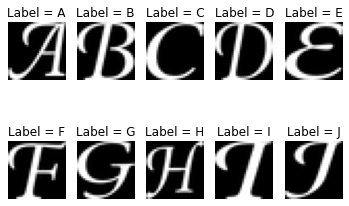

In [9]:
images = []
for i in tqdm(range(len(train_datasets))):
    set_filename = train_datasets[i]
    with open(set_filename, 'rb') as f:
        dataset = pickle.load(f)
    images.append(dataset[1])
print(np.shape(images))

Row = 2
Column = 5
for i, image in enumerate(images):
    plt.subplot(Row, Column, i+1)
    plt.title('Label = {}'.format(os.path.basename(train_datasets[i])[0]))
    plt.imshow(image, cmap='gray')
    plt.axis('off')
plt.show()

## 트레이닝셋, 테스트셋 개수 확인

In [10]:
print("==== 트레이닝셋을 위한 데이터들 ====")
for i in range(len(train_datasets)):
    set_filename = train_datasets[i]
    with open(set_filename, 'rb') as f:
        dataset = pickle.load(f)
    print("글자 {} 에 대한 트레이닝 데이터 개수는 {} 개입니다.".format(os.path.basename(set_filename)[0], len(dataset)))

print("\n==== 테스트셋을 위한 데이터들 =====")
for i in range(len(test_datasets)):
    set_filename = test_datasets[i]
    with open(set_filename, 'rb') as f:
        dataset = pickle.load(f)
    print("글자 {} 에 대한 테스트 데이터 개수는 {} 개입니다.".format(os.path.basename(set_filename)[0], len(dataset)))

==== 트레이닝셋을 위한 데이터들 ====
글자 A 에 대한 트레이닝 데이터 개수는 52909 개입니다.
글자 B 에 대한 트레이닝 데이터 개수는 52911 개입니다.
글자 C 에 대한 트레이닝 데이터 개수는 52912 개입니다.
글자 D 에 대한 트레이닝 데이터 개수는 52911 개입니다.
글자 E 에 대한 트레이닝 데이터 개수는 52912 개입니다.
글자 F 에 대한 트레이닝 데이터 개수는 52912 개입니다.
글자 G 에 대한 트레이닝 데이터 개수는 52912 개입니다.
글자 H 에 대한 트레이닝 데이터 개수는 52912 개입니다.
글자 I 에 대한 트레이닝 데이터 개수는 52912 개입니다.
글자 J 에 대한 트레이닝 데이터 개수는 52911 개입니다.

==== 테스트셋을 위한 데이터들 =====
글자 A 에 대한 테스트 데이터 개수는 1872 개입니다.
글자 B 에 대한 테스트 데이터 개수는 1873 개입니다.
글자 C 에 대한 테스트 데이터 개수는 1873 개입니다.
글자 D 에 대한 테스트 데이터 개수는 1873 개입니다.
글자 E 에 대한 테스트 데이터 개수는 1873 개입니다.
글자 F 에 대한 테스트 데이터 개수는 1872 개입니다.
글자 G 에 대한 테스트 데이터 개수는 1872 개입니다.
글자 H 에 대한 테스트 데이터 개수는 1872 개입니다.
글자 I 에 대한 테스트 데이터 개수는 1872 개입니다.
글자 J 에 대한 테스트 데이터 개수는 1872 개입니다.


## 각 글자 별로 나뉘어져있던 데이터를 합쳐서 트레이닝셋, 테스트셋 2개로 만들기

In [11]:
def merge_datasets(pickle_files, dataset_size):
    num_classes = len(pickle_files)
    dataset = np.ndarray((dataset_size, image_size, image_size), dtype=np.float32)
    labels = np.ndarray(dataset_size, dtype=np.int32)
    tsize_per_class = dataset_size // num_classes

    start_t = 0
    end_t = tsize_per_class
    for label, pickle_file in enumerate(pickle_files):       
        with open(pickle_file, 'rb') as f:
            letter_set = pickle.load(f)
            np.random.shuffle(letter_set)

            letter = letter_set[0:tsize_per_class, :, :]
            dataset[start_t:end_t, :, :] = letter
            labels[start_t:end_t] = label
            start_t += tsize_per_class
            end_t += tsize_per_class

    return dataset, labels

train_size = 200000
test_size = 10000

train_dataset, train_labels = merge_datasets(train_datasets, train_size)
test_dataset, test_labels = merge_datasets(test_datasets, test_size)

print('Training:', train_dataset.shape, train_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

Training: (200000, 28, 28) (200000,)
Testing: (10000, 28, 28) (10000,)


### 데이터 섞어주기

In [12]:
def shuffle(dataset, labels):
    permutation = np.random.permutation(labels.shape[0])
    shuffled_dataset = dataset[permutation,:,:]
    shuffled_labels = labels[permutation]
    return shuffled_dataset, shuffled_labels

train_dataset, train_labels = shuffle(train_dataset, train_labels)
test_dataset, test_labels = shuffle(test_dataset, test_labels)

### 섞은 후에 다시 한 번 보기

==== 트레이닝 데이터 예시 ====


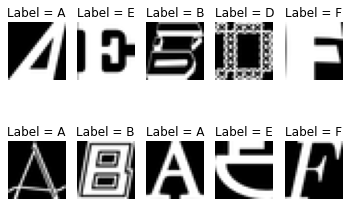

==== 테스트 데이터 예시 ====


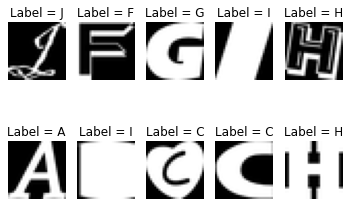

In [13]:
Row = 2
Column = 5
ListOfLabel = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']

print("==== 트레이닝 데이터 예시 ====")
images = train_dataset[0:10]
labels = train_labels[0:10]
for i, image in enumerate(images):
    plt.subplot(Row, Column, i+1)
    plt.title('Label = {}'.format(ListOfLabel[labels[i]]))
    plt.imshow(image, cmap='gray')
    plt.axis('off')
plt.show()

print("==== 테스트 데이터 예시 ====")
images = test_dataset[0:10]
labels = test_labels[0:10]
for i, image in enumerate(images):
    plt.subplot(Row, Column, i+1)
    plt.title('Label = {}'.format(ListOfLabel[labels[i]]))
    plt.imshow(image, cmap='gray')
    plt.axis('off')
plt.show()

## 파일로 내보내기

In [14]:
pickle_file = os.path.join(data_root, 'notMNIST.pickle')

f = open(pickle_file, 'wb')
save = {
    'train_dataset': train_dataset[:50000,],
    'train_labels': train_labels[:50000,],
    'test_dataset': test_dataset[:5000,],
    'test_labels': test_labels[:5000,],
}
pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
f.close()

# 딥러닝 모델을 학습시키기 위해 준비되어야 할 4가지 요소

**1. 데이터**

2. 모델
3. 손실 함수(목적함수, objective function, loss function 등으로 불려요): 정답과 모델의 예측값을 어떤 식으로 비교할지 결정해주는 함수
4. Optimizer: gradient descent를 해줄 애. 즉, 모델의 파라미터를 어느 방향으로 조금 수정할지 결정하고 수정해주는 함수

# Part 2: PyTorch를 이용해서 Convolutional Neural Network 정의해보기

In [15]:
%matplotlib inline

import torch
import torchvision
import torchvision.transforms as transforms

import os
import random
import numpy as np
from six.moves import range
from six.moves import cPickle as pickle

import matplotlib.pyplot as plt

## 모델에 데이터 넣을 준비하기

우선 사용하고 싶은 데이터 파일이 있다면 
1. 그걸 우선 numpy array 형식으로 불러와야 해요.
2. 그리고는 필요한 전처리를 해준 후에 
3. 이 numpy array를 `torch.*Tensor` 형식으로 변환하고 
4. dataloader에 넣어주면 pytorch로 짠 딥러닝 모델에 넣을 준비가 된 거예요.

대개 이제 이런 데이터 처리를 도와주는 패키지들이 있는데<br/>
이미지는 openCV, Pillow를 많이 쓰고,<br/>
텍스트에는 SpaCy를 많이 사용합니다. <br/>

여기서는 매우 간단한 이미지 데이터를 사용하므로 별도의 패키지를 쓰지는 않을게요 

### 1. 데이터셋 불러오기

이미 앞서서 numpy형식으로 저장을 해뒀죠? <br/>
그러니까 그냥 로드만 해주면 됩니다. <br/>
고마워 pickle! <br/>

In [16]:
pickle_file = 'data/notMNIST.pickle'

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    train_dataset = save['train_dataset']
    train_labels = save['train_labels']
    test_dataset = save['test_dataset']
    test_labels = save['test_labels']
    del save  # garbage collector(gc)에게 "이거 지워도 된단다"라고 넌지시 알려주기 
    print('Training set', train_dataset.shape, train_labels.shape)
    print('Test set', test_dataset.shape, test_labels.shape)

Training set (50000, 28, 28) (50000,)
Test set (5000, 28, 28) (5000,)


### ~심심하니까~ 이미지 한 번 더 확인해줍니다

==== 트레이닝 데이터 예시 ====
[4 1 9 8 7 1 3 2 5 7]


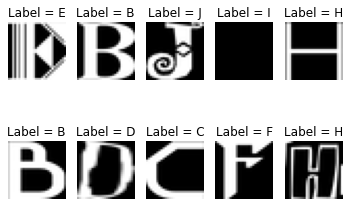

In [17]:
Row = 2
Column = 5
classes = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']

print("==== 트레이닝 데이터 예시 ====")
rand = random.randint(0, 29989)  # 그냥 아무 랜덤한 이미지들을 뽑아내기 위해서 index 역할을 해줄 숫자 하나를 뽑아볼게요.
images = train_dataset[rand:rand+10]
labels = train_labels[rand:rand+10]
print(labels)
for i, image in enumerate(images):
    plt.subplot(Row, Column, i+1)
    plt.title('Label = {}'.format(classes[labels[i]]))
    plt.imshow(image, cmap='gray')
    plt.axis('off')
plt.show()

### 2. 전처리

In [18]:
image_size = 28  # notMNIST 데이터는 이미지 크기가 28x28이였죠?
num_labels = 10  # 클래스 개수는 10개구요.

# 트레이닝셋, 테스트셋 이미지들의 차원 배치를 좀 바꿔줍니다.
x_train = train_dataset.reshape(-1, 1, 28, 28)  # 왜 1일까요? 흑백 이미지
x_test = test_dataset.reshape(-1, 1, 28, 28)

y_train = train_labels
y_test = test_labels

print(x_train.shape, x_test.shape)
print(y_train.shape, y_test.shape)

(50000, 1, 28, 28) (5000, 1, 28, 28)
(50000,) (5000,)


### 3. tensor로 바꿔주기

In [19]:
x_train = torch.tensor(x_train)
y_train = torch.tensor(y_train, dtype=torch.int64)

x_test = torch.tensor(x_test)
y_test = torch.tensor(y_test, dtype=torch.int64)

### 4. data loader에 넣어주기

In [20]:
train_set = torch.utils.data.TensorDataset(x_train, y_train)
test_set = torch.utils.data.TensorDataset(x_test, y_test)

batch_size = 16  # 데이터를 모델에 16개씩 넣어주겠다는 의미예요
train_loader = torch.utils.data.DataLoader(dataset=train_set, 
                                           batch_size=batch_size, 
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_set, 
                                          batch_size=batch_size, 
                                          shuffle=False)

## 학습 이미지 예시 보기

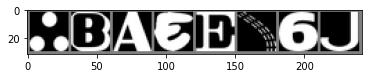

    I     B     A     E     E     A     G     J


In [21]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img + 0.5     # 아까 앞에서 normalize해줘서 색깔 이미지가 이상해져있을 거기 때문에 보기 편하라고 다시 unnormalize해줍니다
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images[:8]))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(8)))

# 딥러닝 모델을 학습시키기 위해 준비되어야 할 4가지 요소

1. 데이터

**2. 모델**
3. Loss function (손실함수, 목적함수, objective function 등으로 불려요): 정답과 모델의 예측값을 어떤 식으로 비교할지 결정해주는 함수
4. Optimizer: gradient descent를 해줄 애. 즉, 모델의 파라미터를 어느 방향으로 조금 수정할지 결정하고 수정해주는 함수

## 모델 정의하기

In [30]:
import torch.nn as nn

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square convolution
        self.conv1 = nn.Conv2d(1, 6, 3, stride=1, padding=1)  # yes, zero padding. 
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()
        ############### TODO: fc layer를 완성 해보세요 ################
        
        # self.fc = nn.Linear(인풋 숫자 , 아웃풋 숫자 )
        # [28, 28, 1] =(padding)=> [30,30,1] => [27,27,1] => [27,27,1] => [28,28,1] => [28,28,6] (conv1을 통과했을 때)
        # [28,28,6] =(pooling)=> [28/2, 28/2, 6] = [14,14,6] =(relu)=> [14,14,6] (pool 를 통과했을 때)
        # [14,14,6] = [14,14,6] (relu)
        self.fc = nn.Linear(14 * 14 * 6, 10)
        
        ########################################################


    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        # print("view 이전 x의 모양: ", x.shape)
        
        # 위 3줄을 줄여서 표현한 게 아래예요.
        # x = self.pool(self.relu(self.conv1(x)))

        ############### TODO: 빈칸을 완성 해보세요 ################
        x = x.view(-1, 1176)
        # x = x.view(-1, 여긴 뭐가 들어가야 할까요)  # 얘의 기능은 텐서의 모양을 원하는 모양으로 바꿔주는 거예요
        # 예시: x가 만약 (16, 3, 12, 12) 모양이었다면 x.view(-1, 144)는 (48, 144) 모양으로 바꿔준답니다. -1은 나머지 숫자를 자동으로 채워주는 역할이에요

        # print("view 이후 x의 모양: ", x.shape)
        
        ########################################################
        x = self.fc(x)

        return x
    

net = Net()

# 딥러닝 모델을 학습시키기 위해 준비되어야 할 4가지 요소

1. 데이터
2. 모델

**3. Loss function (손실함수, 목적함수, objective function 등으로 불려요)**: 정답과 모델의 예측값을 어떤 식으로 비교할지 결정해주는 함수

**4. Optimizer**: gradient descent를 해줄 애. 즉, 모델의 파라미터를 어느 방향으로 조금 수정할지 결정하고 수정해주는 함수

## Loss function과 Optimizer 정의하기

Cross-entropy loss function과 SGD optimizer를 씁니다.


In [31]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## 모델 학습시키기

이제
* data loader
* model
* loss function
* optimizer

이 4가지가 모두 준비되었으니 학습을 할 준비가 끝났습니다.

```
종료 조건 만족할 때까지 아래를 반복:
    1. 우리의 data loader로부터 데이터를 받아와서 모델에 넣어주고
    2. 모델의 출력 값을 받아서 
    3. loss function 값을 계산하고
    4. 그 loss를 바탕으로 backprop(=gradient를 계산) 해준 뒤 
    5. optimizer가 gradient descent를 1 step 진행합니다.
    ```

In [32]:
loss_history = []  # 우리 모델이 어떻게 학습되는지, loss가 잘 떨어지는지 확인하기 위해 매 step loss를 저장해놓을 배열

In [33]:
for epoch in range(2):  # 전체 데이터셋을 몇 번 반복할 건지

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # data에는 이미지와 정답 라벨이 들어있죠?
        inputs, labels = data
        
        # Batch_dim, Channel_dim, Height, Width: BCHW라고 줄여서 말하기도 합니다. 또는 NCHW
        # inputs의 모양은 (16, 1, 28, 28)일 거예요. batch_size 16개, channel 1개, height, width 각 28.
        # 흔히 이걸 batch_first 형태라고 해요.
        
        # 매 반복마다 이전 gradient를 한 번 지워줍니다.
        optimizer.zero_grad()

        # 모델에 데이터 넣어서 forward 해주고 
        # backprop(=backward)으로 이번 input에 대해 gradient를 계산해주고
        # optimizer가 gradient descent 1스텝 진행
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # 결과치 화면에 뿌려주기
        running_loss += loss.item()
        if i % 300 == 299:    
            
            # 300 미니배치마다 트레이닝셋에 대한 loss값 출력
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 300))
            
            # 나중에 시각화를 위해 중간중간 따로 loss값 저장
            loss_history.append(running_loss / 300)
            running_loss = 0.0
            
print('학습 끝!')

[1,   300] loss: 1.523
[1,   600] loss: 0.832
[1,   900] loss: 0.748
[1,  1200] loss: 0.718
[1,  1500] loss: 0.756
[1,  1800] loss: 0.725
[1,  2100] loss: 0.694
[1,  2400] loss: 0.686
[1,  2700] loss: 0.685
[1,  3000] loss: 0.665
[2,   300] loss: 0.635
[2,   600] loss: 0.668
[2,   900] loss: 0.663
[2,  1200] loss: 0.638
[2,  1500] loss: 0.654
[2,  1800] loss: 0.646
[2,  2100] loss: 0.627
[2,  2400] loss: 0.612
[2,  2700] loss: 0.653
[2,  3000] loss: 0.604
학습 끝!


### 학습 경과 살펴보기

사실 저렇게 출력된 숫자들만 보면 감이 잘 오지 않는 거 같아요 그쵸?<br/>
그래서 그래프로 트레이닝셋에 대해 loss가 잘 떨어지는지 살펴보는 게 필요해요<br/>
우리가 방금 위에서 정의한 loss_history 배열에는 학습 중간중간 저장해놓았던 트레이닝셋에 대한 loss 값들이 있어요. <br/>
얘를 시각화 해볼게요

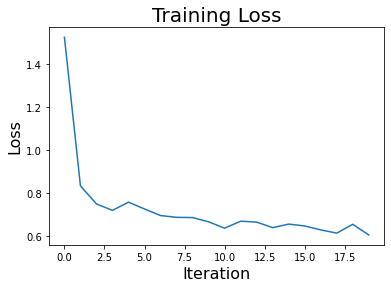

In [34]:
plt.plot(loss_history) 
plt.title('Training Loss', fontsize=20)  # 여기에 한글을 넣고 싶으시다구요? 그럼 좀 귀찮은 몇 가지 작업들을 해야 합니다... 그러므로 패스
plt.xlabel('Iteration',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.show()

## 모델 저장하기

학습이 끝난 모델의 파라미터를 저장해두면 나중에 필요할 때 불러와서 가져다 쓰면 바로 사용할 수 있어요.

In [35]:
PATH = './notmnist_net.pth'
torch.save(net.state_dict(), PATH)

## 테스트셋에 검증해보기

이제 모델 학습이 끝났으니 테스트 데이터에도 잘하는지 확인을 해봐야 합니다. <br/>
테스트셋 데이터 중 몇 개나 맞히는지 알아볼까요?

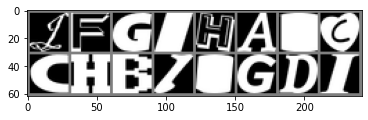

In [36]:
# 테스트셋 이미지 예시도 심심풀이로 한 번 확인해보기
# functions to show an image
def imshow(img):
    img = img + 0.5     # 아까 앞에서 normalize해줘서 색깔 이미지가 이상해져있을 거기 때문에 보기 편하라고 다시 unnormalize해줍니다
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(test_loader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))

### 아까 저장해뒀던 모델 파라미터 불러오기

사실 굳이 불러오지 않고 그냥 위에 있는 `net` 그대로 써도 되지만 <br/>
일단 어떻게 저장하고 불러오는지 여러분이 알아둬야 하니까 여기서는 `net`에 굳이 다시 불러와봤어요

In [37]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

### 불러온 모델로 예측해보기

이미지들을 넣었을 때 모델이 뭐라고 예측하는지 한 번 확인해볼게요.

In [38]:
outputs = net(images)
outputs

tensor([[-1.6747, -2.0119, -0.7459, -0.7808, -0.1141, -2.3958,  0.1460,  0.7146,
          2.0762,  4.1187],
        [ 0.1505, -0.7912, -2.5354, -1.5258,  0.0780,  4.0605, -0.2849,  1.6777,
          0.4266, -2.5523],
        [-0.4263, -3.0427,  2.1745, -2.1511,  1.6730, -2.2032,  7.4937, -2.4329,
          0.0438, -0.3810],
        [-1.5295, -0.0376, -0.0155, -1.1104,  0.3843,  0.3537, -2.1136, -0.8770,
          4.2623,  1.3313],
        [ 1.7931, -0.1159, -1.2337,  1.6499, -1.1781, -2.9758,  0.2501,  2.8186,
         -1.2961, -0.9961],
        [ 6.9674, -0.1217, -3.5618, -1.4170, -0.0442, -4.0261, -0.4216,  0.5922,
          0.8608, -0.6442],
        [-0.3954, -0.7484, -0.6170, -0.2991, -0.0531, -1.7392, -0.2182,  0.0689,
          4.2615,  0.5785],
        [-2.0580,  0.5225, -0.4786,  0.7855, -0.2553, -0.8151,  1.7026,  0.4390,
          1.4649, -1.6856],
        [-0.9855, -5.2054,  8.7771, -4.4562,  5.5556, -2.3203,  3.8946, -2.1799,
          2.3926, -3.9072],
        [ 0.3791,  

뭔지 전혀 모르겠죠? <br/>
각 row에 있는 숫자들은 10개의 클래스에 대한 logit 값이에요. (확률 값이 아니라) <br/>
어떤 인덱스의 logit값이 크면 모델은 그 해당 인덱스의 클래스로 해당 이미지를 분류한다는 의미입니다. <br/>
따라서 그냥 이 logit 값들 중 제일 큰 logit이 있는 index를 각 row마다 뽑아오면 됩니다. <br/>

In [39]:
_, predicted = torch.max(outputs, 1)  # 1번째 차원(=각 row)에서 각각 max인 값과 해당 index를 뽑아옵니다.

classes = ['A', 'B', 'C', 'D', 'E', 'F','G', 'H', 'I', 'J']

print('모델 예측: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(8)))

모델 예측:      J     F     G     I     H     A     I     G


#### 역시 원래 이미지랑 같이 봐야 감이 올 거 같죠?

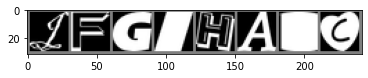

실제 정답:      J     F     G     I     H     A     I     C
모델 예측:      J     F     G     I     H     A     I     G


In [40]:
imshow(torchvision.utils.make_grid(images[:8]))
print('실제 정답: ', ' '.join('%5s' % classes[labels[j]] for j in range(8)))
print('모델 예측: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(8)))

매우 잘 맞히는 거 같습니다! <br/>
그러면 이제 전체 테스트셋에 대해 정답과 비교해서 몇 개나 맞히는지 보겠습니다. 

### 테스트셋 정답률 확인해보기

In [41]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('10000개의 테스트 이미지에 대한 정답률: %d %%' % (
    100 * correct / total))

10000개의 테스트 이미지에 대한 정답률: 90 %


### 각 클래스 별 정답률 확인해보기

In [42]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():  # 매우매우 중요! 테스트셋으로 학습하는 건 반칙입니다. 테스트셋으로 backprop을 하면 안 되지요.
    for data in test_loader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('%5s 클래스의 정답률 : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

    A 클래스의 정답률 : 86 %
    B 클래스의 정답률 : 93 %
    C 클래스의 정답률 : 93 %
    D 클래스의 정답률 : 94 %
    E 클래스의 정답률 : 88 %
    F 클래스의 정답률 : 92 %
    G 클래스의 정답률 : 90 %
    H 클래스의 정답률 : 90 %
    I 클래스의 정답률 : 87 %
    J 클래스의 정답률 : 93 %


# 딥러닝 끝!